In [2]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

In [4]:
# 학습 데이터 셋
train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)
# 테스트 데이터 셋
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:02<00:00, 4.69MB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 159kB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.47MB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 5.13MB/s]


In [5]:
# 데이터 샘플 시각화 함수
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28,28)

    plt.imshow(img, cmap='gray')
    plt.show()

/var/folders/dc/3dqm8vys2qv2c52_q3sn76xr0000gn/T/ipykernel_49870/3931429246.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img = (np.array(x.detach().cpu(), dtype='float')).reshape(28,28)


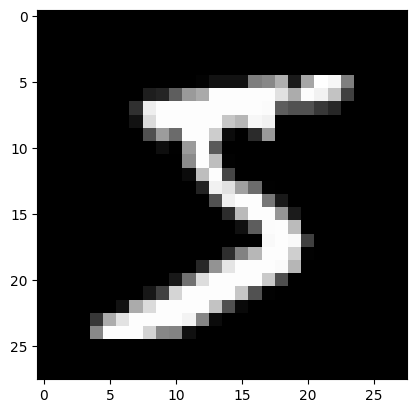

In [6]:
plot(train.data[0])

In [7]:
x = train.data.float() / 255
y = train.targets

x = x.view(x.size(0), -1)
print(x.shape, y.shape)

torch.Size([60000, 784]) torch.Size([60000])


In [10]:
input_size = x.size(-1)
output_size = int(max(y)) + 1

print('input_size: %d, output_size: %d' % (input_size, output_size))

input_size: 784, output_size: 10


In [13]:
# 학습 데이터와 검증 데이터를 8:2 비율로 나눔
# Train / Valid ratio

ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0]) # 학습 데이터 셋
valid_cnt = int(x.size(0) * ratios[1]) # 검증 데이터 셋
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x,y):
    print(x_i.size(), y_i.size())

Train 48000 / Valid 12000 / Test 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [14]:
# 학습 코드 구현
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500,400),
    nn.LeakyReLU(),
    nn.Linear(400,300),
    nn.LeakyReLU(),
    nn.Linear(300,200),
    nn.LeakyReLU(),
    nn.Linear(200,100),
    nn.LeakyReLU(),
    nn.Linear(100,50),
    nn.LeakyReLU(),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1),
)

In [15]:
# 가중치 파라미터를 아담 옵티마이저에 등록하고 NLL손실 함수도 선언
# NLL손실함수를 사용하기 위해 로그 소프트맥스 함수를 모델 마지막에 사용
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()

In [17]:
# GPU 사용
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [19]:
# 모델은 이동 텐서는 복사
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

In [20]:
# 하이퍼 파라미터 초기화
n_epochs = 1000
batch_size = 256
print_interval = 10
lowest_loss = np.inf
best_model = None
early_stop = 50
lowest_epoch = np.inf

In [22]:
train_history, valid_history = [],[]

import time
start = time.time()
for i in range(n_epochs):
    #shuffles
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_,y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss += float(loss) # 메모리 손실을 없애기 위해

    train_loss = train_loss / len(x_)

    with torch.no_grad(): # 계산 그래프 생성을 하지 않음 (forward만 하고 backward는 하지 않음)
        # shuffle 과정 필요 없음
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_,y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())

            valid_loss += float(loss)

            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(x_) # 1epoch 당 평균 손실값(검증)

    # 손실곡선을 그리기 위해 손실 값 저장
    train_history += [train_loss] # epoch 마다 학습 솔실 값 차례로 저장
    valid_history += [valid_loss] # epoch 마다 학습 솔실 값 차례로 저장

    # 출력
    if(i+1) % print_interval == 0:
        print('Epoch %d/%d: train_loss=%.4f valid_loss=%.4f lowest_loss=%.4f elapsed_time=%.2fsec' % (
            (i+1), n_epochs,
            train_loss,
            valid_loss,
            lowest_loss,
            time.time() - start
        ))
        start = time.time()

    # 검증 손실의 최소값 찾기
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict()) # 최소손실일 때 모델을 저장
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i+1:
            print('There is no improvement during last %d epochs.' % early_stop)
            break
            
# 학습 종료 후
print('The best validation loss from epoch %d : %.4e' % (lowest_epoch + 1, lowest_loss))

model.load_state_dict(best_model) # 최소 손실 모델로 복귀

Epoch 10/1000: train_loss=0.0251 valid_loss=0.1193 lowest_loss=0.1041 elapsed_time=6.73sec
Epoch 20/1000: train_loss=0.0110 valid_loss=0.1157 lowest_loss=0.1041 elapsed_time=6.90sec
Epoch 30/1000: train_loss=0.0079 valid_loss=0.1257 lowest_loss=0.1041 elapsed_time=6.70sec
Epoch 40/1000: train_loss=0.0055 valid_loss=0.1395 lowest_loss=0.1041 elapsed_time=6.81sec
Epoch 50/1000: train_loss=0.0012 valid_loss=0.1426 lowest_loss=0.1041 elapsed_time=6.65sec
There is no improvement during last 50 epochs.
The best validation loss from epoch 9 : 1.0412e-01


<All keys matched successfully>

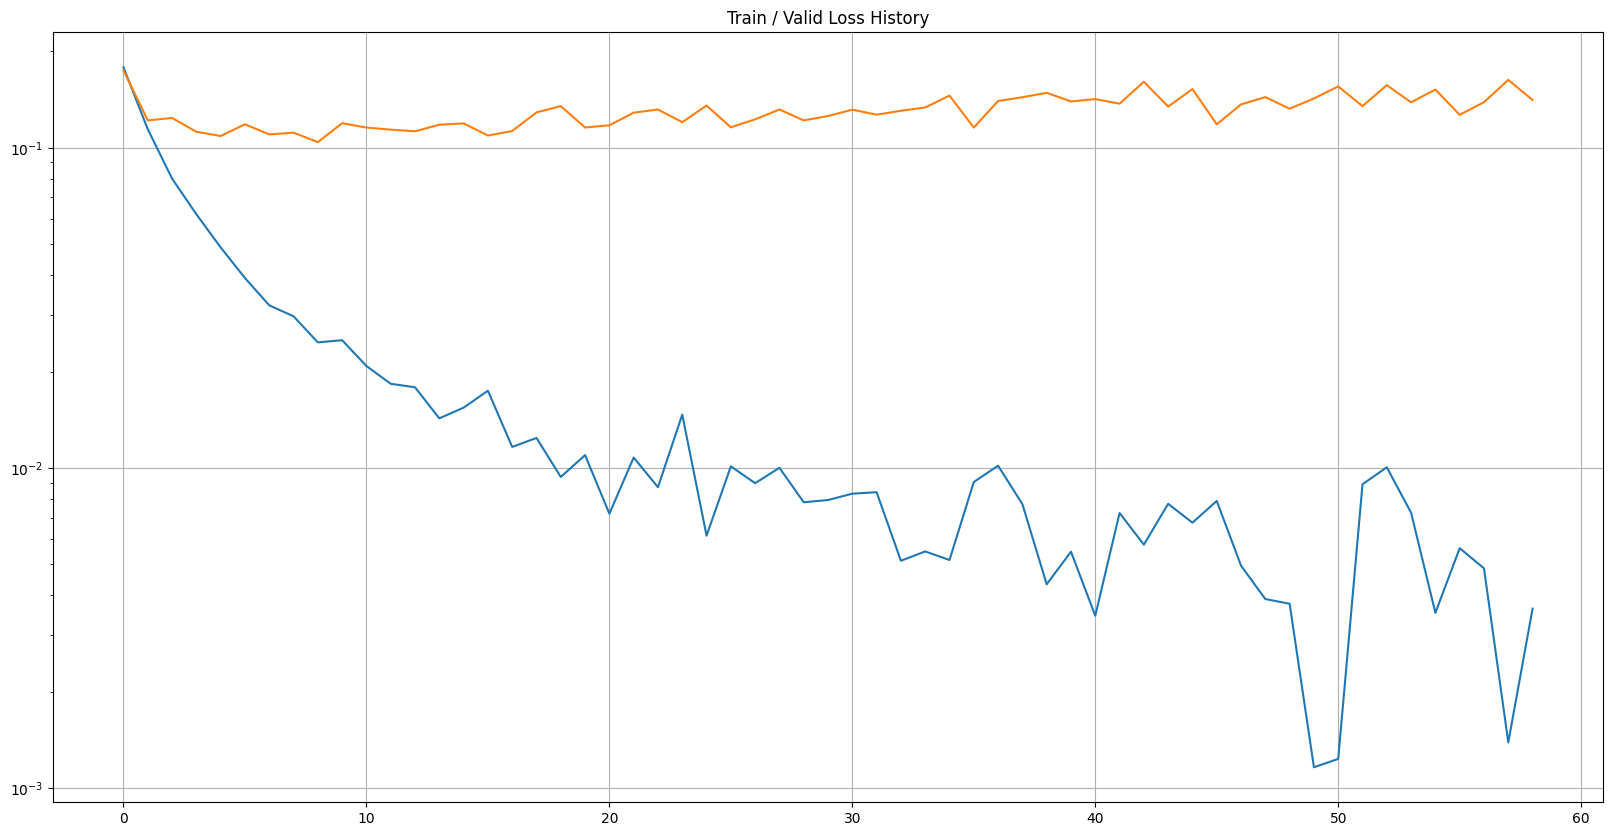

In [23]:
# 손실곡선 확인

plot_from = 0

plt.figure(figsize=(20,10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

In [25]:
# 테스트 데이터 셋에 대한 성능 측정
test_loss = 0
y_hat = []

with torch.no_grad(): # 계산 그래프 생성을 하지 않음 (forward만 하고 backward는 하지 않음)
    # shuffle 과정 필요 없음
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_,y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss
        
        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Test loss: %.4f" % test_loss)

Test loss: 0.0866


In [28]:
# 정확도 측정
# 분류 문제이므로 신경망의 마지막 계층은 확률 값 또는 로그 확률 값을 나타내고 있을 것
# 마지막 계층의 출력 값 중 가장 높은 값을 가지고 있는 클래스 인덱스가 모델이 예측한 클래스의 인덱스

correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print("Test Accuracy: %.4f" % (correct_cnt / total_cnt))

Test Accuracy: 0.9787


In [29]:
# 혼동행렬 출력
import pandas as pd
from sklearn.metrics import confusion_matrix

In [31]:
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
    index=['true_%d' % i for i in range(10)],
    columns=['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,972,1,1,1,1,0,1,1,2,0
true_1,0,1129,0,0,0,1,1,0,4,0
true_2,3,1,1020,2,0,0,3,2,1,0
true_3,1,0,11,976,0,13,0,2,4,3
true_4,1,1,4,0,955,0,7,3,1,10
true_5,3,0,0,4,1,871,5,0,7,1
true_6,4,3,0,0,4,3,943,0,1,0
true_7,2,3,12,1,0,0,0,1001,3,6
true_8,3,1,6,3,2,1,3,2,949,4
true_9,3,3,0,4,16,4,1,4,3,971
